# Exploratory data analysis

In this document I will take a closer look at the sales of the company. First I will study the key metrics of invoices, such as an amount and number of items. I will check seasonality and geographical peculiarities of the business.

In [1]:
import pandas as pd
import matplotlib.pylab as pylab
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sales_data = pd.read_hdf("cleaned_sales.hdf")

In [2]:
# Let's transform dataframe from Item-based to invoice-based.

In [3]:
# This can be done with less code, but I prefer to have things explicit
data = sales_data[['Invoice','Quantity','Amount']].groupby("Invoice").sum()
data['cID'] = sales_data[['Invoice','cID']].groupby("Invoice").first()
data['InvoiceDate'] = sales_data[['Invoice','InvoiceDate']].groupby("Invoice").first()
data['Country'] = sales_data[['Invoice','Country']].groupby("Invoice").first()

In [4]:
data.describe()

,Quantity,Amount,cID
count,36975.000000,36975.000000,36975.000000
mean,281.921920,461.459499,15298.058364
std,1077.188852,938.916806,1721.211549
min,0.000000,0.000000,12346.000000
25%,72.000000,156.500000,13802.000000
50%,153.000000,301.150000,15218.000000
75%,289.000000,480.135000,16791.000000
max,87167.000000,43627.600000,18287.000000


In [5]:
# Removing empty invoices
data = data.query("Amount > 0")
# Note that we remove invoices with 0 GBP as a final bill, which is not the same as 0 quantity - 
# there is some small amount of invoices for free items.

In [6]:
data.describe()

,Quantity,Amount,cID
count,36731.000000,36731.000000,36731.000000
mean,283.436906,464.524924,15300.281914
std,1078.621874,941.274169,1721.155875
min,1.000000,0.380000,12346.000000
25%,74.000000,158.940000,13803.000000
50%,154.000000,301.950000,15222.000000
75%,290.000000,482.455000,16794.000000
max,87167.000000,43627.600000,18287.000000


### Looking at scatter plot of invoices

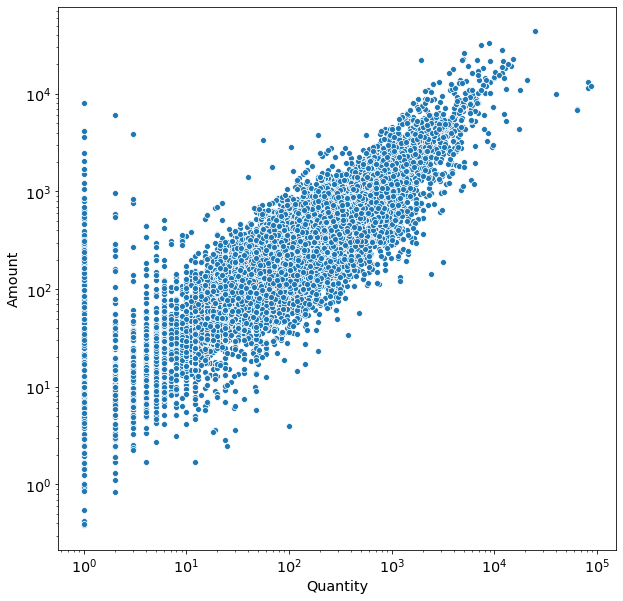

In [7]:
f, ax = plt.subplots()
sns.scatterplot(data=data, x="Quantity", y="Amount", ax = ax)
plt.xscale('log')
plt.yscale('log')

Very expensive invoices with low quantity of items are intriguing. Let's see what's there.

In [8]:
sales_data.query("Price > 100")['StockCode'].value_counts()

M          113
22655       51
22827       37
22656       36
POST        35
22823       18
ADJUST      14
DOT         12
21760       12
22828       12
22826       11
C2           2
ADJUST2      2
85070        2
22502        2
D            1
84965B       1
Name: StockCode, dtype: int64

In [9]:
sales_data.query("StockCode == 'DOT'").head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,cID,old_index,Quantity_c
842968,564764.0,DOT,DOTCOM POSTAGE,1.0,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,11.17,14096.0,842968,0.0


In [10]:
sales_data.query("StockCode == 'M'").head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,cID,old_index,Quantity_c
11310,490300.0,M,Manual,1.0,2009-12-04 14:19:00,0.85,12970.0,United Kingdom,0.85,12970.0,11310,0.0


In [11]:
sales_data.query("StockCode == 22827").head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,cID,old_index,Quantity_c
406342,528325.0,22827,GIANT SEVENTEEN DRAWER SIDEBOARD,1.0,2010-10-21 13:02:00,165.0,15680.0,United Kingdom,165.0,15680.0,406342,0.0


This is admixture of expensie items with real stock codes and artefacts of errors in filling the databse: it looks like someone manually filed the invoice and added the price to the database without going into detalis of the items inside. This makes `Quantity` not very reliable value for the data analysis.

### See time dependence

Let's see if sales depends on season

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


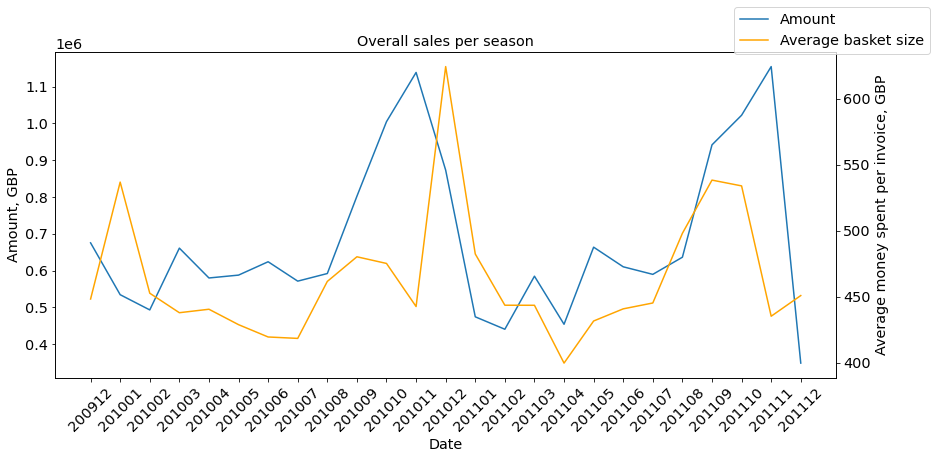

In [12]:
data['MonthYear'] = data['InvoiceDate'].apply(lambda x:x.strftime('%Y%m'))
month_data = data.groupby("MonthYear")['Amount','Quantity'].sum()
month_data['Number'] = data.reset_index().groupby("MonthYear")['Invoice'].count()
month_data['Average_Price'] = month_data['Amount']/month_data['Number']


plt.figure(figsize=(14,6))
plt.xticks(rotation=45) 
plt.title("Overall sales per season")

ax = sns.lineplot(data=month_data['Amount'], label="Amount",legend=False)
ax.set_ylabel("Amount, GBP")
plt.xlabel("Date")
ax2 = plt.twinx()
# sns.lineplot(data=month_data['Number'], label="Number of purchaces",ax = ax2, color = "orange", legend=False)
# ax2.set_ylabel("Number of purcheaces")
sns.lineplot(data=month_data['Average_Price'], label="Average basket size",ax = ax2, color = "orange", legend=False)
ax2.set_ylabel("Average money spent per invoice, GBP")
ax.figure.legend()




As expected, there is a clear peak of purchases in October/November - right before the winter holidays. 
Interesting to note that in October and December the average amount spent per invoice seems to increase: 
 * The December peak is supported by data from  2009 and 2010 
 * The October peak is supported by data from  2010 and 2011
 
Let's see how busines operates during the week

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


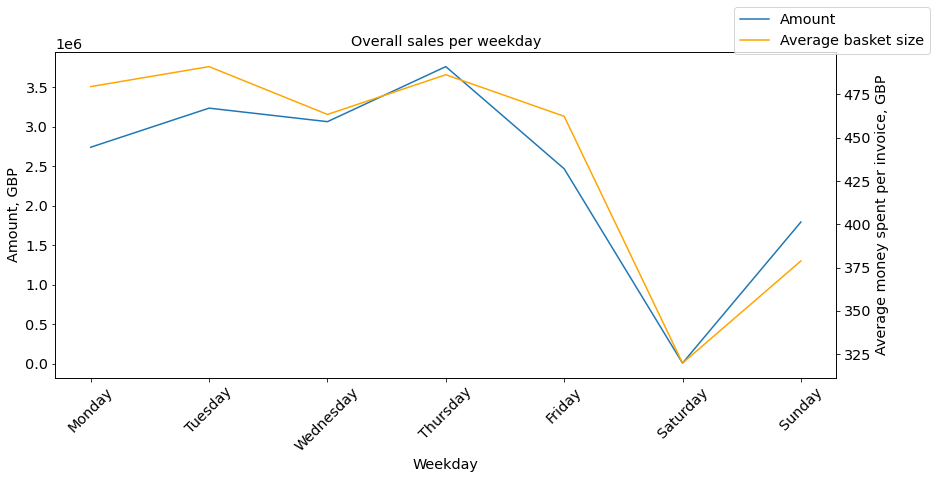

In [13]:
data['Weekday'] = data['InvoiceDate'].dt.dayofweek
weekday_data = data.groupby("Weekday")['Amount','Quantity'].sum()
weekday_data['Number'] = data.reset_index().groupby("Weekday")['Invoice'].count()
weekday_data['Average_Price'] = weekday_data['Amount']/weekday_data['Number']


plt.figure(figsize=(14,6))
plt.xticks(rotation=45) 
plt.title("Overall sales per weekday")

ax = sns.lineplot(data=weekday_data['Amount'], label="Amount",legend=False)
ax.set_ylabel("Amount, GBP")
plt.xlabel("Weekday")
ax2 = plt.twinx()
# sns.lineplot(data=weekday_data['Number'], label="Number of purchaces",ax = ax2, color = "orange", legend=False)
# ax2.set_ylabel("Number of purcheaces")
sns.lineplot(data=weekday_data['Average_Price'], label="Average basket size",ax = ax2, color = "orange", legend=False)
ax2.set_ylabel("Average money spent per invoice, GBP")
plt.xticks(range(7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.figure.legend()



Most of orders comes at workdays, some come at Sundays and very few at Saturdays. Perhaps there is some business reson with this. 

How is the workday structured? 
(This can be relevant for optimisation of the load on the website, for example)

/Users/ilya/Env_For_All/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


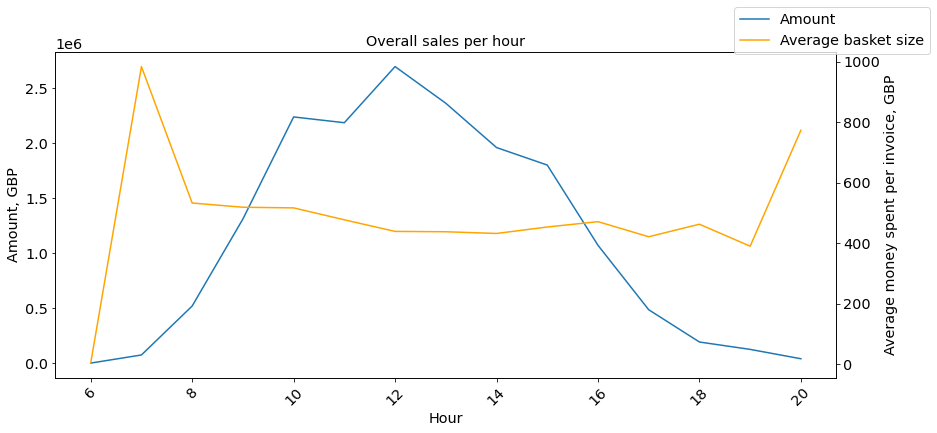

In [14]:
data['Hour'] = data['InvoiceDate'].dt.hour
hourly_data = data.groupby("Hour")['Amount','Quantity'].sum()
hourly_data['Number'] = data.reset_index().groupby("Hour")['Invoice'].count()
hourly_data['Average_Price'] = hourly_data['Amount']/hourly_data['Number']


plt.figure(figsize=(14,6))
plt.xticks(rotation=45) 
plt.title("Overall sales per hour")
# 
ax = sns.lineplot(data=hourly_data['Amount'], label="Amount",legend=False)
ax.set_ylabel("Amount, GBP")
plt.xlabel("Hour")
ax2 = plt.twinx()
# sns.lineplot(data=weekday_data['Number'], label="Number of purchaces",ax = ax2, color = "orange", legend=False)
# ax2.set_ylabel("Number of purcheaces")
sns.lineplot(data=hourly_data['Average_Price'], label="Average basket size",ax = ax2, color = "orange", legend=False)
ax2.set_ylabel("Average money spent per invoice, GBP")
# plt.xticks(range(6),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.figure.legend()

Most of the orders come during the daytime (London). There are preaks of basket size in the beginning and in the end of the day, but this is likely dute to the low amount of data in these points.

In [15]:
day_hour_data =  data.reset_index().groupby(["Hour","Weekday"])['Invoice'].count()

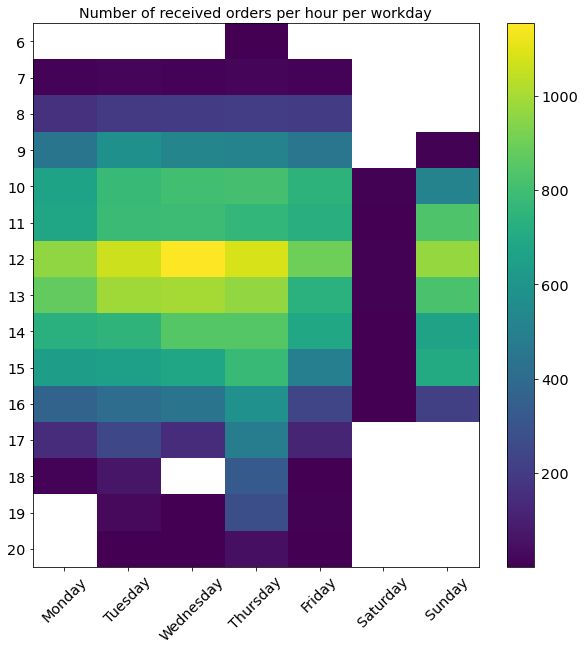

In [16]:
plt.figure(figsize=(10,10))
plt.xticks(rotation=45) 
plt.title("Number of received orders per hour per workday")
orders_per_hour = day_hour_data.unstack().to_numpy()
plt.imshow(orders_per_hour, aspect='auto')
plt.colorbar()
plt.xticks(range(7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.yticks(range(15), range(6,21))
p = plt.show()

The most busy time comes at Wednesday noon. No anomalies are found at Sunday, though I could expect some orders early in the morning/late in the afternoon due to the difference in timezones.

### See geography

In this section I want to see were do the orders come from and what regions are the most important for the business.

In [17]:
#Let's first write a function that splits the sales per countries and per regions. 
# I will do it several time to see the dynamics from year to year. That's why I need a function.
def geo_split(data):
    # Load wold data from geopandas library
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Combine the sales by countries
    geo_data  = data[['Amount','Country']].groupby("Country").sum()
    geo_data['Number']  = data.reset_index()[['Invoice','Country']].groupby("Country").count()
    
    # Map the sales to the world data
    for c in geo_data.index:
        if c in world.name.values:
            world.loc[world.name==c,'Amount'] = geo_data.loc[c,'Amount']
            world.loc[world.name==c,'Number'] = geo_data.loc[c,'Number']
            continue
        if c in world.iso_a3.values:
            world.loc[world.iso_a3==c,'Amount'] = geo_data.loc[c,'Amount']
            world.loc[world.iso_a3==c,'Number'] = geo_data.loc[c,'Number']
            continue
            
    # When we try to do this exercise iteratively, we discover that 
    # these countries and territories are not recognised in geopandas dataset:
    # European Community
    # Unspecified
    # Bahrain
    # Channel Islands
    # Czech Republic
    # EIRE
    # Korea
    # Malta
    # RSA
    # Singapore
    # West Indies
    # Let's process the leftover cases separately. 
    # For the purpose of visualisation we merge the territories from the sales 
    # database that are not recongnised by geopandas to the nearest bigger ones. 
    # This is rough assumption, but good enough for our purposes, especially given t
    # hat most of the company's business is within UK.
    a_SA = geo_data.loc['Saudi Arabia','Amount'] if 'Saudi Arabia' in geo_data.index else 0
    a_EU = geo_data.loc['European Community','Amount'] if 'European Community' in geo_data.index else 0
    a_BHR = geo_data.loc['Bahrain','Amount'] if 'Bahrain' in geo_data.index else 0
    a_CI = geo_data.loc['Channel Islands','Amount'] if 'Channel Islands' in geo_data.index else 0
    a_CZ = geo_data.loc['Czech Republic','Amount'] if 'Czech Republic' in geo_data.index else 0
    a_EIR = geo_data.loc['EIRE','Amount'] if 'EIRE' in geo_data.index else 0
    a_KOR = geo_data.loc['Korea','Amount'] if 'Korea' in geo_data.index else 0
    a_MAL = geo_data.loc['Malta','Amount'] if 'Malta' in geo_data.index else 0
    a_RSA = geo_data.loc['RSA','Amount'] if 'RSA' in geo_data.index else 0
    a_SP= geo_data.loc['Singapore','Amount'] if 'Singapore' in geo_data.index else 0
    a_WI= geo_data.loc['West Indies','Amount'] if 'West Indies' in geo_data.index else 0
    n_SA = geo_data.loc['Saudi Arabia','Number'] if 'Saudi Arabia' in geo_data.index else 0
    n_EU = geo_data.loc['European Community','Number'] if 'European Community' in geo_data.index else 0
    n_BHR = geo_data.loc['Bahrain','Number'] if 'Bahrain' in geo_data.index else 0
    n_CI = geo_data.loc['Channel Islands','Number'] if 'Channel Islands' in geo_data.index else 0
    n_CZ = geo_data.loc['Czech Republic','Number'] if 'Czech Republic' in geo_data.index else 0
    n_EIR = geo_data.loc['EIRE','Number'] if 'EIRE' in geo_data.index else 0
    n_KOR = geo_data.loc['Korea','Number'] if 'Korea' in geo_data.index else 0
    n_MAL = geo_data.loc['Malta','Number'] if 'Malta' in geo_data.index else 0
    n_RSA = geo_data.loc['RSA','Number'] if 'RSA' in geo_data.index else 0
    n_SP= geo_data.loc['Singapore','Number'] if 'Singapore' in geo_data.index else 0
    n_WI= geo_data.loc['West Indies','Number'] if 'West Indies' in geo_data.index else 0    
    
    world.loc[world.name=='Saudi Arabia','Amount'] = a_SA+a_BHR
    world.loc[world.name=='United Kingdom','Amount'] = geo_data.loc['United Kingdom','Amount']+ a_CI
    world.loc[world.name=='Czechia','Amount'] = a_CZ
    world.loc[world.name=='Ireland','Amount'] = a_EIR
    world.loc[world.name=='South Korea','Amount'] = a_KOR
    world.loc[world.name=='Italy','Amount'] = geo_data.loc['Italy','Amount']+a_MAL
    world.loc[world.name=='South Africa','Amount'] = a_RSA
    world.loc[world.name=='Malaysia','Amount'] = a_SP
    world.loc[world.name=='Cuba','Amount'] = a_WI

    world.loc[world.name=='Saudi Arabia','Number'] = n_SA+n_BHR
    world.loc[world.name=='United Kingdom','Number'] = geo_data.loc['United Kingdom','Number']+ n_CI
    world.loc[world.name=='Czechia','Number'] = n_CZ
    world.loc[world.name=='Ireland','Number'] = n_EIR
    world.loc[world.name=='South Korea','Number'] = n_KOR
    world.loc[world.name=='Italy','Number'] = geo_data.loc['Italy','Number']+n_MAL
    world.loc[world.name=='South Africa','Number'] = n_RSA
    world.loc[world.name=='Malaysia','Number'] = n_SP
    world.loc[world.name=='Cuba','Number'] = n_WI

    
    # Now, let's do the split by regions.
    # I put UK as a separate region
    region_data = world[['Amount','Number','continent']].groupby("continent").sum()
    region_data.loc['Europe','Amount'] = region_data.loc['Europe','Amount']+a_EU\
                                            -world.loc[world.name=='United Kingdom','Amount'].values[0]
    region_data.loc['Europe','Number'] = region_data.loc['Europe','Number']+n_EU\
                                            -world.loc[world.name=='United Kingdom','Number'].values[0]

    region_data = region_data.append(world.query("name == 'United Kingdom'")[['name','Amount','Number']].set_index("name"))
    
    region_data = region_data.query("Amount>0").sort_values("Amount",ascending = False)
    
    return world, region_data

In [18]:
world, region_data = geo_split(data)

Let's visualise sales

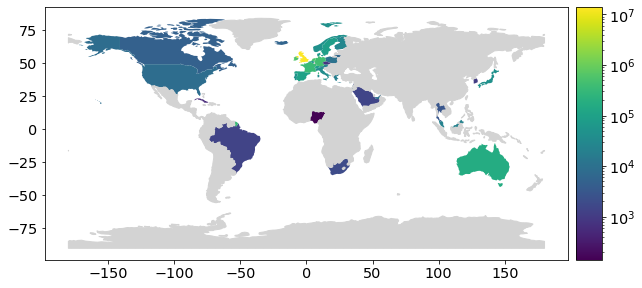

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='Amount', ax=ax, legend=True, cax=cax,norm=LogNorm(), missing_kwds={
"color": "lightgrey",
"edgecolor": "lightgrey",
"hatch": "///",
"label": "Missing values",
},)

This map shows how much money do each country send to the company. UK is a clear leader, followed by Europe, Australia, and Japan. 

Let's see now what countries do bring the most money and where from the most expensive orders come.

In [20]:
world['Average_Price'] = world['Amount']/world['Number']

In [21]:
world[['name','Amount']].sort_values("Amount",ascending = False).head(10)

,name,Amount
143,United Kingdom,1.417381e+07
133,Ireland,5.947592e+05
130,Netherlands,5.491144e+05
121,Germany,4.247900e+05
43,France,3.500828e+05
137,Australia,1.688125e+05
132,Spain,1.059498e+05
127,Switzerland,9.892689e+04
110,Sweden,8.653287e+04
142,Denmark,6.596214e+04


As expected, the most of sales of the company is done within UK, it is followed by the neighbouring European countries, Autralia, and, surprisingly, Japan. Sales to the other regions are negligible.


Let's see now top 10 countries by the average basket size

In [22]:
world[['name','Average_Price','Amount']].sort_values("Average_Price",ascending = False).head(10)

,name,Average_Price,Amount
130,Netherlands,2440.508311,549114.37
148,Malaysia,2310.139000,23101.39
137,Australia,1795.877340,168812.47
77,Lebanon,1693.880000,1693.88
155,Japan,1561.839310,45293.34
91,Thailand,1535.270000,3070.54
142,Denmark,1534.003256,65962.14
76,Israel,1475.664286,10329.65
127,Switzerland,1150.312674,98926.89
133,Ireland,1097.341624,594759.16


The biggest orders come from Netherlands, Singapour, and Australia (don't mind "Malaysia" in the table abowe - we associated Singapour to to Malaysia for the purpose of visualisation earlier).

Finaly, let's visualise how the influx of money distributed among the regions

In [28]:
world_10, region_data_10 = geo_split(data[data['InvoiceDate'].dt.year == 2010])
world_11, region_data_11 = geo_split(data[data['InvoiceDate'].dt.year == 2011])
region_data = pd.merge(region_data_10.reset_index(),region_data_11.reset_index(),\
                       on='index', suffixes = ('_10','_11'))

Text(0.5, 1.0, 'Overall sales per region')

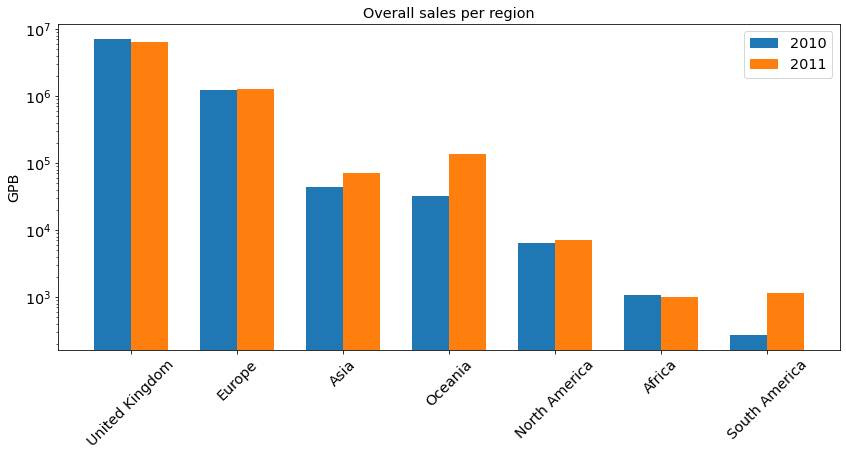

In [29]:
plt.figure(figsize=(14,6))
plt.xticks(rotation=45) 
plt.title("Sales per region")
width = 0.35
plt.bar(np.arange(region_data.shape[0])-width/2, region_data['Amount_10'], width, label = "2010")
plt.bar(np.arange(region_data.shape[0])+width/2, region_data['Amount_11'], width, label = "2011")
plt.xticks(range(region_data.shape[0]),region_data['index'])
plt.yscale('log')
plt.ylabel('GPB')
plt.legend()
plt.title("Overall sales per region")


Most of money come from UK, around 10% come from Europe, and 1% is shared between Japan and Australia. Sales in other regions are negligible. In 2011, company significantly increased its sales in Asia and Oceania, which is a good sign given the large average amount of money spent by customers from that regions.

## Conclusions

We learned that:
* Company sells goods for around ten millions GBP per year.
* Most of money come from UK, around 10% come from Europe, and 1% is shared between Japan and Australia. Sales in other regions are negligible
* While UK buyers brings most money to the company, the average UK order is quite small (around 400 GBP). Buyers from Nethrelands leave in average around 2500 GBP per each order. The second place here belongs to Singapur,  and the third - to Australia.
* In 2011, company significantly increased its sales in Asia and Oceania, which is a good sign given the large average amount of money spent by customers from that countries.
* As expected, the busiest months for the company are October and November.
* People tend to spend more per single order in December and September.
* Company receives orders during the London day time, almost no orders are received at Saturdays, and the busies weekday is Wednesday.

In [27]:
data.to_hdf("invoices.hdf",key="df")